# Traitement Numérique du Signal pour les Télécommunications

Par Mathieu Delcluze et Paul Jouhaud

In [171]:
include("script.jl");

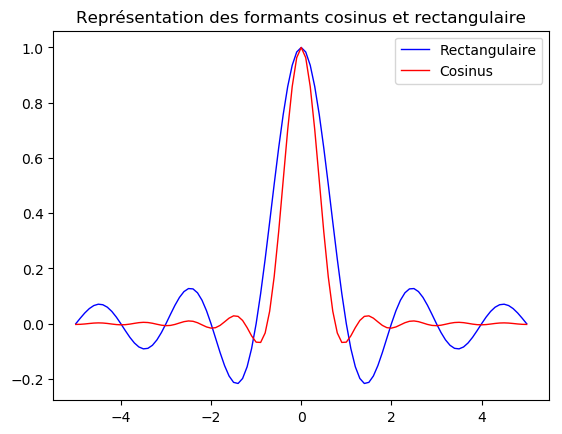

In [2]:
# Affiche les formants cosinus et rectangulaire

surechantillonnage = 10;
taille_formant = 10 * surechantillonnage + 1;
formant_rect = formantrect(taille_formant, surechantillonnage);
formant_cos = formantcos(taille_formant, surechantillonnage);

xrect = collect(1:length(formant_rect));
xrect = (xrect - (length(formant_rect) + 1) / 2) / surechantillonnage;
xcos = collect(1:length(formant_cos));
xcos = (xcos - (length(formant_cos) + 1) / 2) / surechantillonnage;

plot(xrect, formant_rect, "blue", xcos, formant_cos, "red", linewidth=1);
title("Représentation des formants cosinus et rectangulaire");
legend(["Rectangulaire", "Cosinus"]);
savefig("data/formants.png");

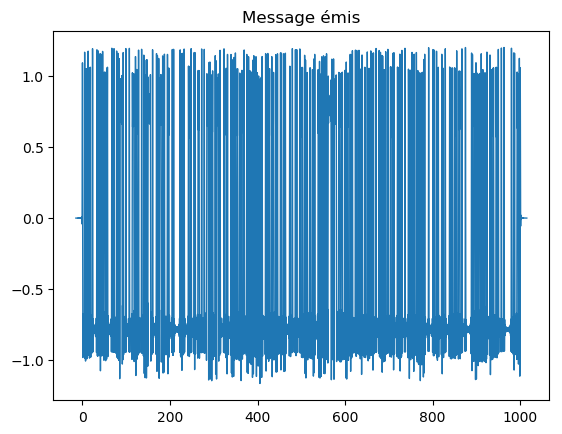

In [3]:
# Vérifie le bon fonctionnement de l'émetteur

taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;

message = 2 * (randn(taille_message) .> 0.5) - 1;
formant = formantcos(surechantillonnage * taille_formant + 1, surechantillonnage);
signal = emission(message, formant, surechantillonnage);

x = linspace(-taille_formant / 2 + 1 / surechantillonnage, taille_formant / 2 + taille_message, length(signal));
plot(x, signal, linewidth=1);
title("Message émis");
savefig("data/message.png");

Nombre d'erreurs : 0

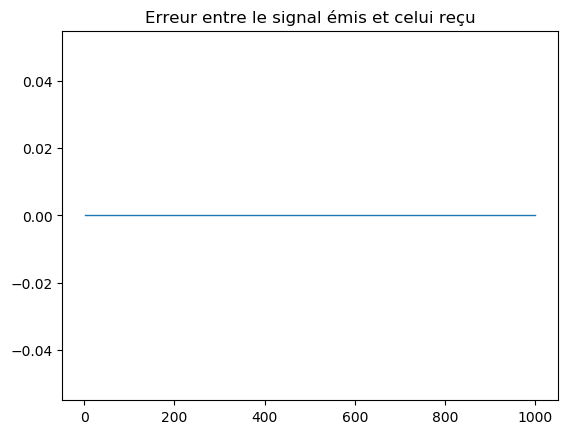

.0

In [4]:
# Vérifie le bon fonctionnement du récepteur

taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;

message = 2 * (randn(taille_message) .> 0.5) - 1;
formant = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
signal = emission(message, formant, surechantillonnage);
filtre = formant[length(formant):-1:1] / (formant'*formant);
recu = reception(signal, filtre, surechantillonnage, 1+taille_formant*surechantillonnage/2);
recu = recu[1:length(message)];
erreur = abs.(recu-message)/2 ;
print("Nombre d'erreurs : ");
print(sum(erreur));

x = collect(1:taille_message);
plot(x, erreur, linewidth=1);
title("Erreur entre le signal émis et celui reçu");
savefig("data/erreur_emis_recu.png");

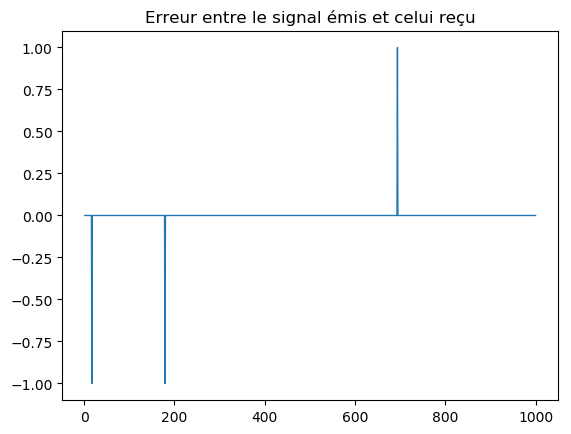

Nombre d'erreurs : 0.0

In [5]:
# Ajout d'un bruit de canal

taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;

message = 2 * (randn(taille_message) .> 0.5) - 1;
formant = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
signal = emission(message, formant, surechantillonnage);
signal = signal + bruit(5, formant'*formant, length(signal));
filtre = formant[length(formant):-1:1] / (formant'*formant);
recu = reception(signal, filtre, surechantillonnage, 1+taille_formant*surechantillonnage/2);
recu = recu[1:length(message)];
erreur_message = abs.(recu-message)/2 ;
print("Nombre d'erreurs : ");
print(sum(erreur));

x = collect(1:taille_message);
plot(x, (recu-message)/2 , linewidth=1);
title("Erreur entre le signal émis et celui reçu");
savefig("data/erreur_emis_recu_bruitee.png");

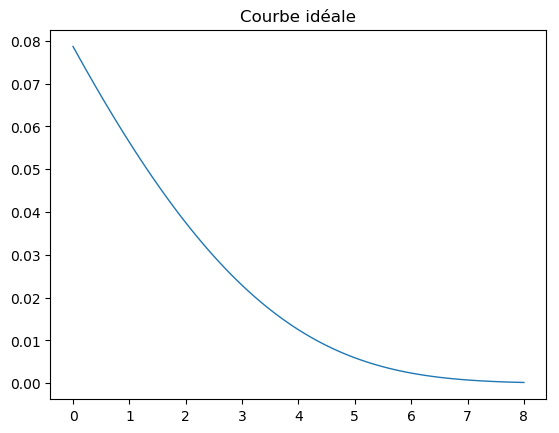

In [6]:
# Courbes de taux d'erreur
# Taux d'erreur théorique de la chaîne de transmission idéale

x = collect(0:0.1:8);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end
plot(x, y, linewidth=1);
title("Courbe idéale");
savefig("data/courbe_ideale.png");

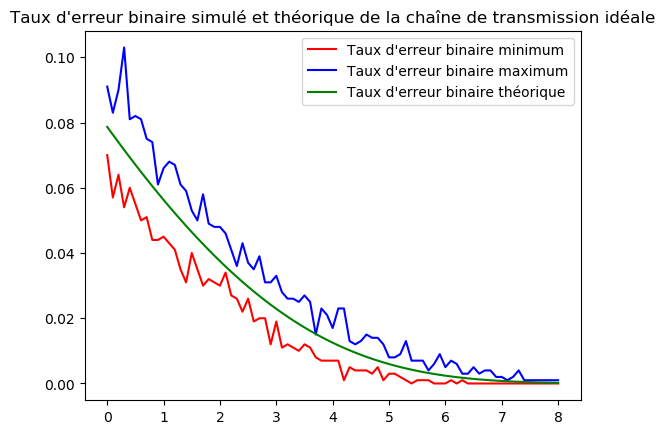

In [7]:
# Taux d'erreur simulé de la chaîne de transmission idéale
# courbe_ideale_simulee.jl

# Initialisation des paramètres
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
teb_min = zeros(81);
teb_max = zeros(81);
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:test_number)
        temp_teb = erreur_function(x, taille_message, surechantillonnage, formant_base, formant_filtre);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Taux d'erreur binaire simulé et théorique de la chaîne de transmission idéale");
legend(["Taux d'erreur binaire minimum", "Taux d'erreur binaire maximum", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_ideale_simulee.png");

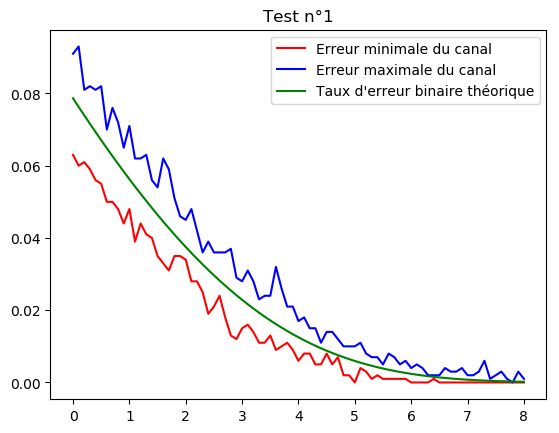

In [8]:
# Chaîne de transmission non-idéale
# Introduction d’une déformation dans le canal
# Test 1

# Initialisation des paramètres
N = 10;
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;

# Initialisation des variables
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
teb_min = zeros(81);
teb_max = zeros(81);

# Initialisation du canal
canal = [1];

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Test n°1");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_test1.png");

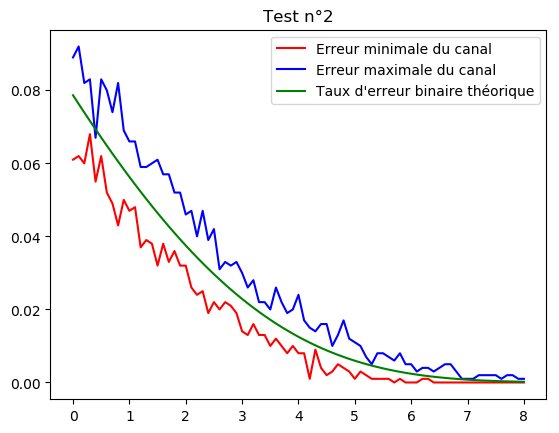

In [9]:
# Test 2

# Initialisation des paramètres
N = 10;
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
teb_min = zeros(81);
teb_max = zeros(81);

# Initialisation du canal
x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid] = 1;

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Test n°2");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_test2.png");

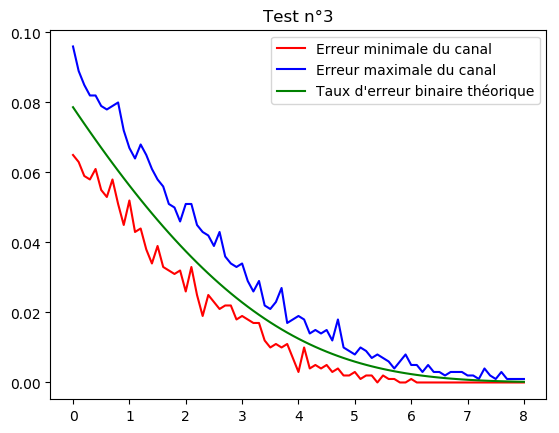

In [10]:
# Test 3

# Initialisation des paramètres
N = 10;
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
teb_min = zeros(81);
teb_max = zeros(81);

# Initialisation du canal
x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid] = 10;

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Test n°3");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_test3.png");

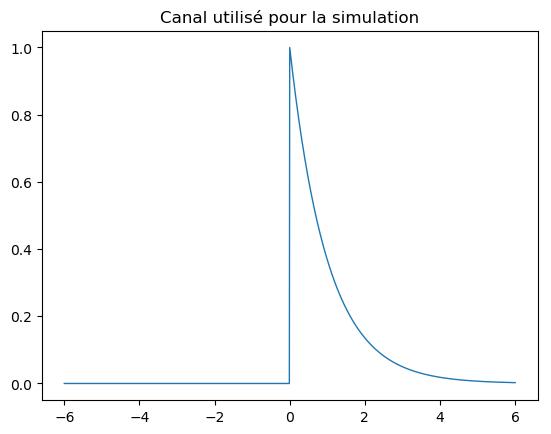

In [11]:
# Canal pour test final

x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);
plot(x_canal, canal, linewidth=1);
title("Canal utilisé pour la simulation");
savefig("data/canal_simulee.png");

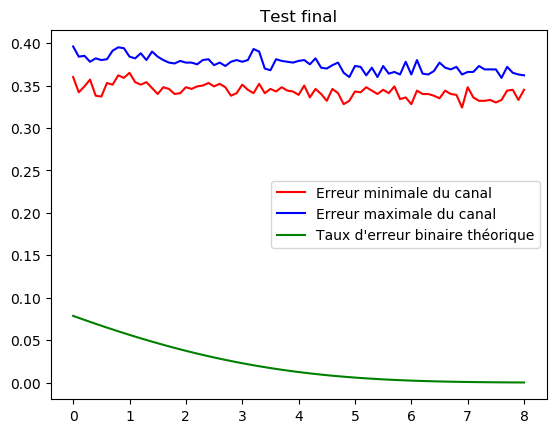

In [173]:
# Test complet

# Initialisation des paramètres
N = 10;
taille_message = 1000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
teb_min = zeros(81);
teb_max = zeros(81);
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

# Initialisation du canal
x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);


for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Test final");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee.png");

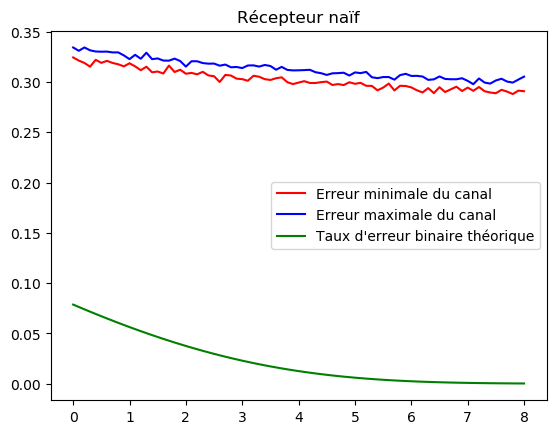

In [13]:
# Récepteur adapté au canal déformé
# Récepteur naïf avec filtre adapté de la chaîne de transmission idéale

# Initialisation des paramètres
N = 10;
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
teb_min = zeros(81);
teb_max = zeros(81);
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);

# Définition du canal
x_canal = collect(-6:0.01:6);
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);

# Définition du filtre
filtre = conv(canal, formant_base);
filtre = filtre[end:-1:1]/(filtre'*filtre);

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, filtre, formant_filtre, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage de graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Récepteur naïf");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_naive.png");

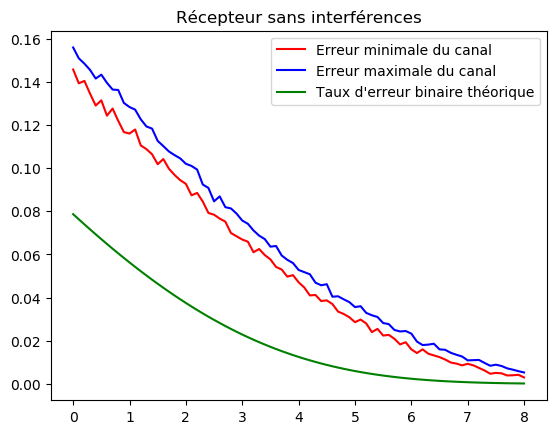

In [14]:
# Récepteur avec élimination des interférences entre symboles

# Initialisation des paramètres
N = 10;
taille_message = 10000;
surechantillonnage = 30;
taille_formant = 30;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
teb_min = zeros(81);
teb_max = zeros(81);

# Définition du canal
x_canal = collect(-6*surechantillonnage:6*surechantillonnage)./surechantillonnage;
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);

# Définition du filtre
filtre = conv(formant_base, canal);
filtre = filtre./(filtre'*filtre);
filtre = filtre[length(filtre):-1:1];

# Calcul des interférences
interferences = calcul_interferences(surechantillonnage, formant_base, filtre, canal);

temp = interferences[Int(floor(1+length(interferences)/2)):length(interferences)];
interferences = vcat(temp, interferences[1:Int(floor(length(interferences)/2))]);
interferences_inverses = real(ifft(1./fft(interferences)));

temp = interferences_inverses[1:Int(floor(length(interferences_inverses)/2) + 1)];
interferences_inverses = vcat(interferences_inverses[Int(floor(length(interferences_inverses)/2)+2):length(interferences_inverses)], temp);

interferences_inverses_analogique = zeros(((length(interferences_inverses)-1) * surechantillonnage)+1);
interferences_inverses_analogique[1:surechantillonnage:length(interferences_inverses_analogique)] = interferences_inverses;

filtre_interferences = conv(filtre, interferences_inverses_analogique);

for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, filtre_interferences, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end


# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Récepteur sans interférences");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_sansinterference.png");

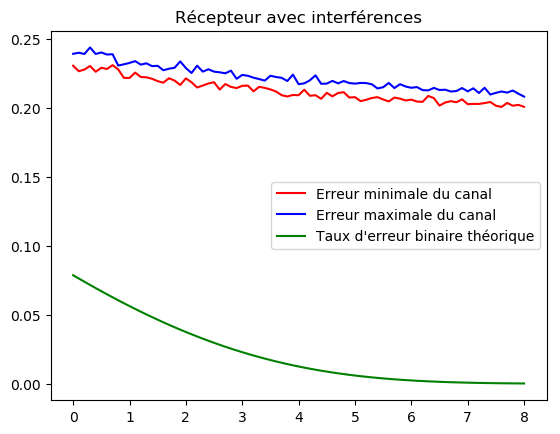

In [174]:
# Récepteur avec interférences entre symboles

# Initialisation des paramètres
N = 10;
taille_message = 10000;
surechantillonnage = 10;
taille_formant = 100;
taille_zero_padding = 15;
length_samples = 8;
samples_step = 0.1;
test_number = 10;

# Initialisation des variables
formant_base = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
formant_filtre = formantcos(surechantillonnage*taille_formant+1, surechantillonnage);
teb_min = zeros(81);
teb_max = zeros(81);

# Initialisation du canal
x_canal = collect(-6*surechantillonnage:6*surechantillonnage)./surechantillonnage;
canal = zeros(length(x_canal));
mid = Int((length(x_canal) + 1)/2);
canal[mid:length(canal)] = exp.(-x_canal[mid:length(canal)]);

# Calcul de l'interférence entre symboles
filtre = conv(canal, formant_base);
filtre = filtre./(filtre'*filtre);
filtre_recepteur_naif = filtre[length(filtre):-1:1];
zero_padding = zeros(taille_zero_padding);
dirac = zeros(2*taille_zero_padding + 1);
dirac[taille_zero_padding + 1] = 1
signal_interference = emission(dirac, formant_base, surechantillonnage);
signal_interference = conv(signal_interference, canal);
recu_interference = conv(signal_interference, filtre_recepteur_naif);
end_interference = length(recu_interference);
recu_interference = recu_interference[1:surechantillonnage:end_interference];
end_interference = length(recu_interference);
recu_interference = vcat(recu_interference[Int((end_interference+1)/2):1:end_interference], recu_interference[1:1:Int((end_interference-1)/2)]);
fft_recu_interference = fft(recu_interference);

message = 2 * (randn(taille_message) .> 0.5) - 1;
signal = emission(message, formant_base, surechantillonnage);
signal = conv(signal, canal);
energie = (signal'*signal)./taille_message;

# Filtre récepteur sans suppression d'interférences
for x = collect(0:samples_step:length_samples)
    times = 1/samples_step;
    i = Int(x*times) + 1
    current_teb_min = 1;
    current_teb_max = 0;
    N0 = energie ./ (10^(x/10));
    interferences_inverses = real(ifft(1./(N0/2 + fft_recu_interference)));
    end_interference = length(interferences_inverses);
    interferences_inverses = vcat(interferences_inverses[Int((end_interference+1)/2+1):1:end_interference], interferences_inverses[1:1:Int((end_interference-1)/2+1)]);
    interferences_inverses_analogique = zeros((length(interferences_inverses)) * surechantillonnage);
    interferences_inverses_analogique[1:surechantillonnage:length(interferences_inverses_analogique)] = interferences_inverses;
    
    h = conv(filtre[length(filtre):-1:1], interferences_inverses_analogique);
    
    for y = collect(1:N)
        temp_teb = erreur_canal(x, taille_message, surechantillonnage, formant_base, h, canal);
        if temp_teb > current_teb_max
            current_teb_max = temp_teb;
        end
        if temp_teb < current_teb_min
            current_teb_min = temp_teb;
        end
    end
    teb_min[i] = current_teb_min;
    teb_max[i] = current_teb_max;
end

# Calcul du taux d'erreur binaire théorique
x = collect(0:samples_step:length_samples);
y = zeros(length(x));
for i = collect(1:length(x))
    y[i] = 0.5 * erfc(sqrt(10^(x[i]/10)));
end

# Affichage des graphes
plot(x, teb_min, "red", x, teb_max, "blue", x, y, "green");
title("Récepteur avec interférences");
legend(["Erreur minimale du canal", "Erreur maximale du canal", "Taux d'erreur binaire théorique"]);
savefig("data/courbe_canal_simulee_avecinterference.png");